<a href="https://colab.research.google.com/github/AlanDarioMoreno/Brisa-Notebooks-Modelos-IA/blob/3_Clases_%2B_Filtro_Gaussiano/Entrenamiento_3_Clases_%2B_Filtro_Gaussiano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import numpy as np
import cv2

def add_gaussianBlur(image_tensor, sigmaX=10):
    # Convertir el tensor de PyTorch a un array de NumPy
    image_np = image_tensor.cpu().numpy()

    # Cambiar el orden de los canales de (C, H, W) a (H, W, C) si es necesario
    if image_np.shape[0] == 3:  # Imagen RGB
        image_np = np.transpose(image_np, (1, 2, 0))

    # Aplicar el filtro Gaussian Blur en OpenCV
    blurred_image = cv2.addWeighted(image_np, 4, cv2.GaussianBlur(image_np, (0, 0), sigmaX), -4, 128)

    # Cambiar de nuevo el orden de los canales de (H, W, C) a (C, H, W) para PyTorch
    if blurred_image.shape[2] == 3:
        blurred_image = np.transpose(blurred_image, (2, 0, 1))

    # Convertir de nuevo a un tensor de PyTorch
    blurred_image_tensor = torch.tensor(blurred_image, dtype=image_tensor.dtype)

    # Mantener la misma forma y dispositivo (CPU o GPU)
    return blurred_image_tensor.to(image_tensor.device)

# Ejemplo de uso:
# Suponiendo que tienes un tensor de imagen de tamaño 512x512 en formato RGB y en el rango [0, 255]
image_tensor = torch.rand(3, 512, 512) * 255  # Ejemplo de tensor de imagen de tamaño 512x512
blurred_image_tensor = add_gaussianBlur(image_tensor)





In [ ]:
# Importar librerías adicionales necesarias
import cv2
import numpy as np
from PIL import Image

# Definir la transformación personalizada para aplicar Gaussian Blur
class GaussianBlurTransform:
    def __init__(self, sigmaX=10):
        self.sigmaX = sigmaX

    def __call__(self, image):
        # Convertir la imagen a un array de NumPy
        image_np = np.array(image)

        # Aplicar el filtro Gaussian Blur de OpenCV
        blurred_image = cv2.addWeighted(image_np, 4, cv2.GaussianBlur(image_np, (0, 0), self.sigmaX), -4, 128)

        # Convertir la imagen de nuevo a formato PIL para compatibilidad con el pipeline de transformaciones
        blurred_image = Image.fromarray(blurred_image)

        return blurred_image


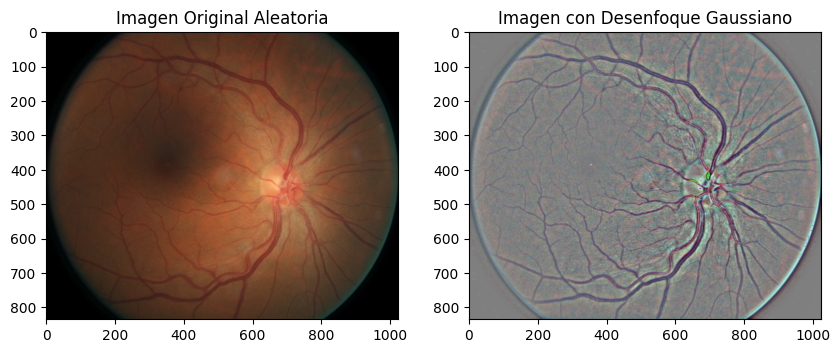

In [ ]:
import torch
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ruta de la carpeta que contiene las imágenes
image_dir = '/content/drive/MyDrive/3Clases/Mild'

#Carga una imagen aleatoria de la carpeta y aplica el desenfoque gaussiano
def process_random_image(image_dir):
    #Selecciona una imagen aleatoria de la carpeta
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Comprueba si hay imágenes
    if not image_files:
        print("No se encontraron imágenes en la carpeta especificada.")
        return

    random_image_path = os.path.join(image_dir, np.random.choice(image_files))

    # Carga la imagen y la convierte de BGR a RGB
    image = cv2.imread(random_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convertir la imagen en un tensor y normalizar al rango [0, 255]
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).float()  # Cambiar a (C, H, W)

    # Aplica el desenfoque gaussiano
    blurred_image_tensor = add_gaussianBlur(image_tensor)

    # Convertir el tensor desenfocado a NumPy para mostrar
    blurred_image_np = blurred_image_tensor.permute(1, 2, 0).cpu().numpy().astype(np.uint8)

    # Mostrar la imagen original y la desenfocada
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Imagen Original Aleatoria")
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.title("Imagen con Desenfoque Gaussiano")
    plt.imshow(blurred_image_np)
    plt.show()

# Ejecutar la función para procesar una imagen aleatoria
process_random_image(image_dir)


In [ ]:
#RESTNET 50

import ssl
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import pretrainedmodels
import cv2
import numpy as np
from PIL import Image


# Desactivar verificación SSL para modelos preentrenados
ssl._create_default_https_context = ssl._create_unverified_context

# Definir la capa de agrupación GeM
def gem(x, p=3, eps=1e-6):
    return nn.functional.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)

# Cargar el modelo preentrenado ResNet50
model_path = '/content/drive/MyDrive/Copia de 1resnet50_v1.pth'

# Cargar el modelo ResNet50 con la capa GeM ya implementada
model = models.resnet50(pretrained=False)
model.avgpool = GeM()
model.fc = nn.Linear(model.fc.in_features, 3)  # Cambiar la capa de salida a 3 clases

# Intentar cargar el modelo preentrenado
try:
    model.load_state_dict(torch.load(model_path))
    print("Modelo cargado exitosamente.")
except FileNotFoundError:
    print("Modelo no encontrado, entrenando desde cero.")

    # Cambiar la capa fc a 3 clases
model.fc = nn.Linear(model.fc.in_features, 3)
print("Modelo cargado y adaptado a 3 clases.")

# Transformaciones de imagen
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    GaussianBlurTransform(),  # Aplicar el filtro Gaussian Blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])


# Cargar el dataset
image_dir = '/content/drive/MyDrive/3Clases'
dataset = datasets.ImageFolder(root=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


# Configuración del dispositivo y criterio de pérdida
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
model.to(device)

# Función para calcular precisión
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    corrects = torch.sum(preds == labels).item()
    return corrects / labels.size(0)

# Inicializar la mejor pérdida como un valor alto al principio
best_loss = float('inf')

# Entrenamiento
num_epochs = 1
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    running_loss = 0.0
    running_accuracy = 0.0
    total_batches = 0

    model.train()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calcular precisión y pérdida para el lote actual
        batch_accuracy = calculate_accuracy(outputs, labels)
        running_loss += loss.item()
        running_accuracy += batch_accuracy
        total_batches += 1

        # Mostrar precisión y pérdida para cada lote
        print(f"Lote {total_batches} - Loss: {loss.item():.4f} - Accuracy: {batch_accuracy * 100:.2f}%")

    # Promedio de pérdida y precisión por época
    epoch_loss = running_loss / total_batches
    epoch_accuracy = (running_accuracy / total_batches) * 100
    print(f"\nEpoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.2f}%")

    # Verificar si la pérdida ha disminuido
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        model_path = '/content/drive/MyDrive/2resnet50_3Clases_gaussian_v1.pth'
        # Guardar el modelo si la pérdida ha disminuido
        torch.save(model.state_dict(), model_path)
        print(f"Modelo guardado en la época {epoch+1} con pérdida de {epoch_loss:.4f}.")

print("Entrenamiento finalizado.")


<ipython-input-12-cf7dfd7d4c7a>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Modelo cargado exitosamente.
Modelo cargado y adaptado a 3 clases.

Epoch 1/1
Lote 1 - Loss: 1.0779 - Accuracy: 37.50%
Lote 2 - Loss: 1.0437 - Accuracy: 43.75%
Lote 3 - Loss: 0.9366 - Accuracy: 48.44%
Lote 4 - Loss: 0.9792 - Accuracy: 45.31%
Lote 5 - Loss: 0.9274 - Accuracy: 59.38%
Lote 6 - Loss: 0.9158 - Accuracy: 54.69%
Lote 7 - Loss: 0.8333 - Accuracy: 71.88%
Lote 8 - Loss: 0.8786 - Accuracy: 65.62%
Lote 9 - Loss: 0.7654 - Accuracy: 79.69%
Lote 10 - Loss: 0.7603 - Accuracy: 78.12%
Lote 11 - Loss: 0.7082 - Accuracy: 84.38%
Lote 12 - Loss: 0.7078 - Accuracy: 87.50%
Lote 13 - Loss: 0.7015 - Accuracy: 87.50%
Lote 14 - Loss: 0.6949 - Accuracy: 79.69%
Lote 15 - Loss: 0.6872 - Accuracy: 85.94%
Lote 16 - Loss: 0.6877 - Accuracy: 78.12%
Lote 17 - Loss: 0.6209 - Accuracy: 90.62%
Lote 18 - Loss: 0.7010 - Accuracy: 76.56%
Lote 19 - Loss: 0.6107 - Accuracy: 89.06%
Lote 20 - Loss: 0.5327 - Accuracy: 93.75%
Lote 21 - Loss: 0.5427 - Accuracy: 90.62%
Lote 22 - Loss: 0.5419 - Accuracy: 90.62%
Lote 23

In [ ]:
# Solo para la Carga del modelo previamente Entrenado
import torch
from torchvision import models

# Definir la capa de agrupación GeM
def gem(x, p=3, eps=1e-6):
    return torch.nn.functional.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(torch.nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = torch.nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)

# Ruta del modelo guardado
model_path = '/content/drive/MyDrive/clases_leves_resnet50_v1.pth'

# Configurar el modelo ResNet50 con la capa GeM
model = models.resnet50(pretrained=False)
model.avgpool = GeM()  # Reemplazar la capa avgpool con GeM
model.fc = torch.nn.Linear(model.fc.in_features, 3)  # Ajustar la capa de salida a 3 clases

# Cargar los pesos del modelo entrenado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
print("Modelo cargado exitosamente y listo para testear.")

<ipython-input-13-8aacc8916cea>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Modelo cargado exitosamente y listo para testear.


In [ ]:
# Importar librerías adicionales necesarias
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Definir la transformación personalizada para aplicar Gaussian Blur
class GaussianBlurTransform:
    def __init__(self, sigmaX=10):
        self.sigmaX = sigmaX

    def __call__(self, image):
        # Convertir la imagen a un array de NumPy
        image_np = np.array(image)

        # Aplicar el filtro Gaussian Blur en OpenCV
        blurred_image = cv2.addWeighted(image_np, 4, cv2.GaussianBlur(image_np, (0, 0), self.sigmaX), -4, 128)

        # Convertir la imagen de nuevo a formato PIL para compatibilidad con el pipeline de transformaciones
        blurred_image = Image.fromarray(blurred_image)

        return blurred_image

# Configuración del dataset de test
test_image_dir = '/content/drive/MyDrive/Colab Notebooks/Test_mild_no_DR_moderate'  # Cambia esto a la ruta de tu dataset de test
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Asegúrate de usar el mismo tamaño de entrada que en el entrenamiento
    GaussianBlurTransform(sigmaX=10),  # Aplica el desenfoque gaussiano
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cargar el dataset de test
test_dataset = datasets.ImageFolder(root=test_image_dir, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# Poner el modelo en modo de evaluación
model.eval()
model.to(device)

# Función para realizar las predicciones y obtener las salidas crudas del modelo
def predict_with_outputs_and_names(model, dataloader, dataset):
    predictions = []
    labels = []
    outputs_list = []  # Para almacenar las salidas crudas (logits)
    image_names = []   # Para almacenar los nombres de las imágenes

    with torch.no_grad():  # Desactiva el cálculo de gradientes para ahorrar memoria
        for i, (images, label) in enumerate(dataloader):
            images = images.to(device)

            # Pasar las imágenes desenfocadas al modelo
            outputs = model(images)  # Obtener la salida cruda del modelo (logits)

            outputs_list.extend(outputs.cpu().numpy())  # Guardar las salidas
            _, preds = torch.max(outputs, 1)  # Obtener las clases predichas
            predictions.extend(preds.cpu().numpy())
            labels.extend(label.numpy())

            # Obtener los nombres de las imágenes desde el dataset
            start_idx = i * dataloader.batch_size
            end_idx = start_idx + len(images)
            image_names.extend([dataset.imgs[idx][0] for idx in range(start_idx, end_idx)])

    return predictions, labels, outputs_list, image_names

# Realizar predicciones en el dataset de test y obtener las salidas
predictions, true_labels, outputs_list, image_names = predict_with_outputs_and_names(model, test_dataloader, test_dataset)

# Mostrar salidas
for idx in range(60):
    print(f"  Imagen: {image_names[idx]}")
    print(f"  Salida del modelo: {outputs_list[idx]}")
    print(f"  Predicción: {predictions[idx]} - Etiqueta Verdadera: {true_labels[idx]}")
    print("---------------------------------------------------------------------------")


  Imagen: /content/drive/MyDrive/Colab Notebooks/Test_mild_no_DR_moderate/mild/24655_right.jpeg
  Salida del modelo: [-1.5124133   0.28808537 -1.0112947 ]
  Predicción: 1 - Etiqueta Verdadera: 0
---------------------------------------------------------------------------
  Imagen: /content/drive/MyDrive/Colab Notebooks/Test_mild_no_DR_moderate/mild/24696_right.jpeg
  Salida del modelo: [-0.0068131  -1.7935417   0.16421697]
  Predicción: 2 - Etiqueta Verdadera: 0
---------------------------------------------------------------------------
  Imagen: /content/drive/MyDrive/Colab Notebooks/Test_mild_no_DR_moderate/mild/27004_right.jpeg
  Salida del modelo: [ 0.4098543  -0.77364236 -0.9858415 ]
  Predicción: 0 - Etiqueta Verdadera: 0
---------------------------------------------------------------------------
  Imagen: /content/drive/MyDrive/Colab Notebooks/Test_mild_no_DR_moderate/mild/27223_right.jpeg
  Salida del modelo: [ 0.28674358 -0.86042    -0.07513532]
  Predicción: 0 - Etiqueta Verda

In [ ]:
from sklearn.metrics import accuracy_score
from collections import defaultdict
import numpy as np

# Función para calcular la precisión por clase
def accuracy_per_class(predictions, true_labels, num_classes):
    correct_counts = defaultdict(int)  # Correct predictions per class
    total_counts = defaultdict(int)    # Total predictions per class

    for pred, true in zip(predictions, true_labels):
        total_counts[true] += 1
        if pred == true:
            correct_counts[true] += 1

    # Calcular porcentaje de precisión por clase
    accuracy_per_class = {}
    for cls in range(num_classes):
        if total_counts[cls] > 0:
            accuracy_per_class[cls] = (correct_counts[cls] / total_counts[cls]) * 100
        else:
            accuracy_per_class[cls] = 0.0  # Si no hay ejemplos de la clase, precisión es 0

    return accuracy_per_class

# Número de clases (ajusta según tu dataset)
num_classes = 3

# Obtener el porcentaje de aciertos por clase
accuracy_per_class_results = accuracy_per_class(predictions, true_labels, num_classes)

# Mostrar resultados de precisión por clase
for cls, acc in accuracy_per_class_results.items():
    print(f"Clase {cls}: {acc:.2f}% de aciertos")


Clase 0: 75.00% de aciertos
Clase 1: 55.00% de aciertos
Clase 2: 65.00% de aciertos
